In [757]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader
import torch.distributions as dists
from torchvision import datasets, transforms
from sklearn.manifold import TSNE
import pandas as pd
import math
import random
import matplotlib.pyplot as plt


In [758]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
setup_seed(1142)

In [759]:
class CNN_VectorQuantizer(nn.Module):
    """
    VQ-VAE layer: Input any tensor to be quantized. 
    Args:
        embedding_dim (int): the dimensionality of the tensors in the
          quantized space. Inputs to the modules must be in this format as well.
        num_embeddings (int): the number of vectors in the quantized space.
        commitment_cost (float): scalar which controls the weighting of the loss terms (see
          equation 4 in the paper - this variable is Beta).
    """
    def __init__(self, embedding_dim, num_embeddings, commitment_cost):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost
        
        # initialize embeddings
        self.embeddings = nn.Embedding(self.num_embeddings, self.embedding_dim)
        
    def forward(self, x):
        # [B, C, H, W] -> [B, H, W, C]
        x = x.permute(0, 2, 3, 1).contiguous()
        # [B, H, W, C] -> [BHW, C]
        flat_x = x.reshape(-1, self.embedding_dim)
        
        encoding_indices = self.get_code_indices(flat_x)
        quantized = self.quantize(encoding_indices)
        quantized = quantized.view_as(x) # [B, H, W, C]
        
        if not self.training:
            quantized = quantized.permute(0, 3, 1, 2).contiguous()
            return quantized,encoding_indices
        
        # embedding loss: move the embeddings towards the encoder's output
        q_latent_loss = F.mse_loss(quantized, x.detach())
        # commitment loss
        e_latent_loss = F.mse_loss(x, quantized.detach())
        loss = q_latent_loss + self.commitment_cost * e_latent_loss

        # Straight Through Estimator
        quantized = x + (quantized - x).detach()
        
        quantized = quantized.permute(0, 3, 1, 2).contiguous()
        return quantized, loss
    
    def get_code_indices(self, flat_x):
        # compute L2 distance
        distances = (
            torch.sum(flat_x ** 2, dim=1, keepdim=True) +
            torch.sum(self.embeddings.weight ** 2, dim=1) -
            2. * torch.matmul(flat_x, self.embeddings.weight.t())
        ) # [N, M]
        encoding_indices = torch.argmin(distances, dim=1) # [N,]
        return encoding_indices
    
    def quantize(self, encoding_indices):
        """Returns embedding tensor for a batch of indices."""
        return self.embeddings(encoding_indices)  

class CNN_Encoder(nn.Module):
    """Encoder of VQ-VAE"""
    
    def __init__(self, in_dim=3, latent_dim=16):
        super().__init__()
        self.in_dim = in_dim
        self.latent_dim = latent_dim
        
        self.convs = nn.Sequential(
            nn.Conv2d(in_dim, 32, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, latent_dim, 1),
        )
        
    def forward(self, x):
        return self.convs(x)
    

class CNN_Decoder(nn.Module):
    """Decoder of VQ-VAE"""
    
    def __init__(self, out_dim=1, latent_dim=16):
        super().__init__()
        self.out_dim = out_dim
        self.latent_dim = latent_dim
        
        self.convs = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, out_dim, 3, padding=1),
        )
        
    def forward(self, x):
        return self.convs(x)

class VQVAE(nn.Module):
    """VQ-VAE"""
    
    def __init__(self, in_dim, embedding_dim, num_embeddings, data_variance, 
                 commitment_cost=0.25):
        super().__init__()
        self.in_dim = in_dim
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.data_variance = data_variance
        
        self.encoder = CNN_Encoder(in_dim, embedding_dim)
        self.vq_layer = CNN_VectorQuantizer(embedding_dim, num_embeddings, commitment_cost)
        self.decoder = CNN_Decoder(in_dim, embedding_dim)
        
    def forward(self, x):
        z = self.encoder(x)
        if not self.training:
            e,enco = self.vq_layer(z)
            x_recon = self.decoder(e)
            return e, x_recon,enco
        
        e, e_q_loss = self.vq_layer(z)
        x_recon = self.decoder(e)
        
        recon_loss = F.mse_loss(x_recon, x) / self.data_variance
        
        return e_q_loss , recon_loss ,F.mse_loss(x_recon, x)   

In [760]:
epochs=10
batch_size = 256
embedding_dim = 16
num_embeddings = 128

In [761]:
print('Load DataSet....')
transform=transforms.Compose([
    transforms.ToTensor(),
])

dataset1 = datasets.FashionMNIST('/data/liumingxuan/SNN-VAE-DMSVDD/datasets/Datasets', train=True, download=True,
                        transform=transform)
dataset2 = datasets.FashionMNIST('/data/liumingxuan/SNN-VAE-DMSVDD/datasets/Datasets', train=False,
                        transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size)
print('done!')

Load DataSet....
done!


In [762]:
print('prepare vq-vae....')
train_images = []
for images, labels in train_loader:
    train_images.append(images)
train_images = torch.cat(train_images, dim=0)
train_data_variance = torch.var(train_images)
model = VQVAE(1, embedding_dim, num_embeddings, train_data_variance)
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images - 0.5 # normalize to [-0.5, 0.5]
        images = images.cuda()
        loss_eq,loss_rec,real_loss_rec = model(images)
        loss = loss_eq+loss_rec
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch {} Loss {:.3f} Loss_eq {:.3f} Loss_rec {:.3f}".format(epoch, loss, loss_eq, real_loss_rec))

prepare vq-vae....
Epoch 0 Loss 0.832 Loss_eq 0.613 Loss_rec 0.027
Epoch 1 Loss 0.528 Loss_eq 0.392 Loss_rec 0.016
Epoch 2 Loss 0.492 Loss_eq 0.368 Loss_rec 0.015
Epoch 3 Loss 0.468 Loss_eq 0.354 Loss_rec 0.014
Epoch 4 Loss 0.425 Loss_eq 0.317 Loss_rec 0.013
Epoch 5 Loss 0.386 Loss_eq 0.287 Loss_rec 0.012
Epoch 6 Loss 0.387 Loss_eq 0.290 Loss_rec 0.012
Epoch 7 Loss 0.353 Loss_eq 0.263 Loss_rec 0.011
Epoch 8 Loss 0.340 Loss_eq 0.255 Loss_rec 0.010
Epoch 9 Loss 0.345 Loss_eq 0.259 Loss_rec 0.010


test vq-vae....


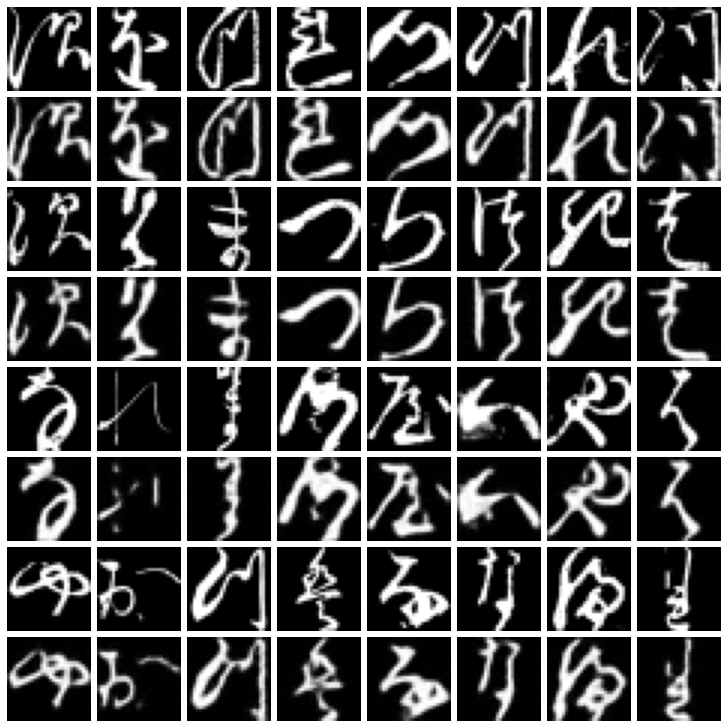

In [763]:
print('test vq-vae....')
# reconstructe images

test_loader_iter = iter(test_loader)
images, labels = next(test_loader_iter)

n_samples = 32
images = images[:n_samples]

model.eval()

norm_images = (images - 0.5).cuda()
with torch.inference_mode():
    e, recon_images,_ = model(norm_images)

recon_images = np.array(np.clip((recon_images + 0.5).cpu().numpy(), 0., 1.) * 255, dtype=np.uint8)
ori_images = np.array(images.numpy() * 255, dtype=np.uint8)

recon_images = recon_images.reshape(4, 8, 28, 28)
ori_images = ori_images.reshape(4, 8, 28, 28)

fig = plt.figure(figsize=(10, 10), constrained_layout=True)
gs = fig.add_gridspec(8, 8)
for n_row in range(4):
    for n_col in range(8):
        f_ax = fig.add_subplot(gs[n_row * 2, n_col])
        f_ax.imshow(ori_images[n_row, n_col], cmap="gray")
        f_ax.axis("off")
        f_ax = fig.add_subplot(gs[n_row * 2 + 1, n_col])
        f_ax.imshow(recon_images[n_row, n_col], cmap="gray")
        f_ax.axis("off")

In [764]:
print('prepare data for train diffusion...')
train_indices = []
for images, labels in train_loader:
    images = images - 0.5 # normalize to [-0.5, 0.5]
    images = images.cuda()
    with torch.inference_mode():
        _,_,encoding_indices = model(images) # [B, C, H, W, T]
        train_indices.append(encoding_indices.reshape(images.shape[0],7,7).cpu())
print(len(train_indices))

prepare data for train diffusion...
235


In [765]:
print((train_indices[0][100]))
mask_id, index = torch.mode(train_indices[0][100])
mask_id = mask_id[0]
mask_id = 0
print("mask_id =" ,mask_id)

tensor([[97, 97, 97, 97, 97, 97, 97],
        [97, 97, 81, 97, 97, 97, 97],
        [97, 23, 28, 22, 97, 80, 92],
        [97, 57, 90, 63, 97, 97, 48],
        [97, 20, 28, 55, 98, 97, 93],
        [48, 66, 80, 37, 95, 90, 95],
        [97, 97, 97, 97, 97, 97, 97]])
mask_id = 0


In [766]:
print('data for train diffusion is ready!')

data for train diffusion is ready!


In [767]:
class AbsorbingDiffusion():

    # H：存放超参数
    # denoise_fn：逆扩散模型，即为一个Transformer模型
    # mask_id：决定mask掉的位置使用哪个参数
    # embedding_weight：vq_vae中embedding层内部的参数
    # aux_weight——暂时不知道
    def __init__(self, denoise_fn, mask_id):
        super().__init__()

        # 类别数量——即codebook的size数量——128
        self.num_classes = 128

        # latent的shape，7x7
        self.shape = [7,7]

        # 时间步数量
        self.num_timesteps = 256

        # mask掉的位置用什么填充
        self.mask_id = mask_id

        # 去噪模型
        self._denoise_fn = denoise_fn

        # 一次采样输出的数量
        self.n_samples = 64


    def sample_time(self, b, device):
        # 这里应该是每次训练都从各种程度的噪声中进行采样
        # 那么从1到num_timesteps之间随机整数采样b个时间步长t
        t = torch.randint(1, self.num_timesteps+1, (b,), device=device).long()

        # 将pt设置为一个全1的张量，除以num_timesteps，表示每个时间步长有相同的概率
        pt = torch.ones_like(t).float() / self.num_timesteps
        return t, pt

    # 它的作用是采样q(x_t | x_0)，即给定x_0的条件下，x_t的概率分布。x_t是加入了噪声和掩码的x_0
    def q_sample(self, x_0, t):
        # samples q(x_t | x_0)
        # randomly set token to mask with probability t/T

        # 输入是原始矩阵x_0和时间t，首先copy一下输入x_t
        x_t, x_0_ignore = x_0.clone(), x_0.clone()
        #print(x_t.shape)
        #print(t.shape)
        # 生成一个与x_t形状相同的随机张量mask，它的元素是0或1，表示是否要掩码某个位置。掩码的概率与t成正比，即t越大，掩码越多
        # 当t最大时mask取全1，这个是一个均匀扩散过程
        t_mask = t.reshape(x_0.shape[0], 1, 1,1)
        t_mask = t_mask.expand(x_0.shape[0], 1, 7, 7)
        
        mask = torch.rand_like(x_t.float()) < (t_mask.float() / self.num_timesteps)

        # 将x_t中mask为1的位置替换为self.mask_id，这是一个特殊的标识符，表示该位置被掩码了。
        x_t[mask] = self.mask_id

        # 将x_0_ignore中mask为0的位置替换为-1，这是一个忽略索引，表示该位置不参与损失计算
        x_0_ignore[torch.bitwise_not(mask)] = -1
        return x_t, x_0_ignore, mask

    # 训练损失如何得到
    # 输入编码矩阵x_0
    def _train_loss(self, x_0):

        # b-batch_size
        b, device = x_0.size(0), x_0.device
        
        # choose what time steps to compute loss at
        # 得到本次训练的时间与每个时间出现的概率，这里每个时间出现的概率相等
        t, pt = self.sample_time(b, device)

        # make x noisy and denoise
        # 输入x_0与t得到掩码噪声后的结果
        x_t, x_0_ignore, mask = self.q_sample(x_0=x_0, t=t)

        # sample p(x_0 | x_t)
        # 调用_denoise_fn函数，对x_t进行去噪，得到x_0_hat_logits，即x_0的预测概率分布
        x_0_hat_logits = self._denoise_fn(x_t, t=t)

        # Always compute ELBO for comparison purposes
        # x_0_ignore(256,1,7,7)
        # x_0_hat_logits(258,128,7,7)
        # 调用F.cross_entropy函数，使用x_0_hat_logits和x_0_ignore计算交叉熵损失，忽略索引为-1的位置，得到每个样本的损失之和cross_entropy_loss
        cross_entropy_loss = F.cross_entropy(x_0_hat_logits.reshape(b,128,49), x_0_ignore.reshape(b,49).type(torch.LongTensor).cuda(), ignore_index=-1, reduction='none').sum(1)
        
        # 计算变分下界vb_loss，即将cross_entropy_loss除以t和pt，并除以log(2)乘以x_0的元素数量。这是为了估计p(x_0)的下界。
        vb_loss = cross_entropy_loss / t
        vb_loss = vb_loss / pt
        vb_loss = vb_loss / (math.log(2) * x_0.shape[1:].numel())

        # 根据loss_type的值，选择不同的损失函数
        loss = vb_loss

        return loss.mean()

    def sample(self, temp=1.0, sample_steps=None):
        b, device = self.n_samples, 'cuda'
        x_t = torch.ones(b,1,7,7, device=device).long() * self.mask_id

        unmasked = torch.zeros_like(x_t, device=device).bool()
        
        sample_steps = list(range(1, sample_steps+1))

        for t in reversed(sample_steps):
            print(f'Sample timestep {t:4d}', end='\r')
            t = torch.full((b,), t, device=device, dtype=torch.long)

            # where to unmask
            # TODO: 随着时间步长的增长 降低已经被回复过的像素的再被回复的概率
            t_mask = t.reshape(b, 1, 1,1)
            t_mask = t_mask.expand(b, 1, 7, 7)
            #print(t_mask.shape)
            #print(x_t.shape)
            changes = torch.rand_like(x_t.float()) < 1/t_mask.float()
            changes = changes.cuda()
            #print(changes.shape)
            # don't unmask somewhere already unmasked
            changes = torch.bitwise_xor(changes, torch.bitwise_and(changes, unmasked))
            # update mask with changes
            unmasked = torch.bitwise_or(unmasked, changes)

            x_0_logits = self._denoise_fn(x_t.float(), t=t)
            #print(x_0_logits.shape)

            # scale by temperature
            x_0_logits = x_0_logits / temp
            index = torch.argmax(x_0_logits, dim=1)
            x_0_hat = index.unsqueeze(1)

            #print(x_0_hat.shape)

            x_t.long()[changes] = x_0_hat.long()[changes]

        return x_t

    def train_iter(self, x):
        loss = self._train_loss(x)
        stats = {'loss': loss}
        return stats

In [768]:
blk = lambda ic, oc: nn.Sequential(
    nn.Conv2d(ic, oc, 3, 1, 1),
    nn.BatchNorm2d(oc),
    nn.LeakyReLU(),
)

class DummyModel(nn.Module):
    """
    This should be transformer, but let's don't think about the model too much :P
    Basically, any universal R^n -> R^n model should work.
    """
    # batch_size 1 7 7 
    # batch_size  1287 7
    # batch_size 1 7 7 
    def __init__(self, n_channel: int) -> None:
        super(DummyModel, self).__init__()
        self.conv = nn.Sequential(  # with batchnorm
            blk(n_channel, 64),
            blk(64,128),
            blk(128, 256),
            blk(256, 512),
            blk(512, 256),
            blk(256, 256),
            nn.Conv2d(256, 128, 3, 1,1),
        )

    def forward(self, x, t) -> torch.Tensor:
        # Lets think about using t later. In the paper, they used Tr-like positional embeddings.
        return self.conv(x)


In [769]:
denoise_fn = DummyModel(1).cuda()
abdiff = AbsorbingDiffusion(denoise_fn, mask_id=mask_id)

Epoch 0  Loss 3.276
Epoch 1  Loss 3.118
Epoch 2  Loss 2.801
Epoch 3  Loss 2.935
Epoch 4  Loss 2.836


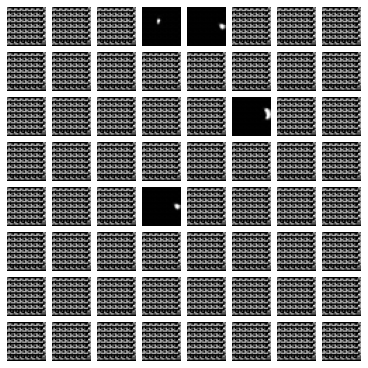

Epoch 5  Loss 2.645
Epoch 6  Loss 2.718
Epoch 7  Loss 2.747
Epoch 8  Loss 2.807
Epoch 9  Loss 2.722


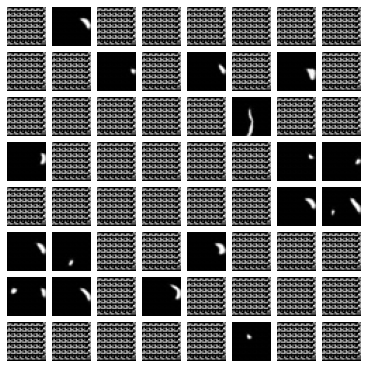

Epoch 10  Loss 2.900
Epoch 11  Loss 2.632
Epoch 12  Loss 2.646
Epoch 13  Loss 2.725
Epoch 14  Loss 2.668


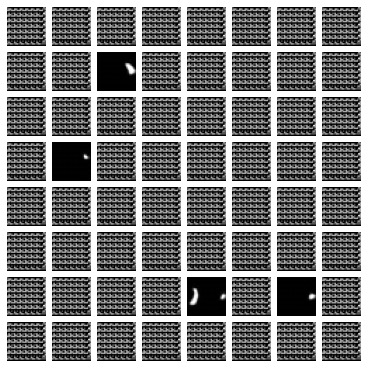

Epoch 15  Loss 2.656
Epoch 16  Loss 2.647
Epoch 17  Loss 2.526
Epoch 18  Loss 2.561
Epoch 19  Loss 2.634


In [770]:
epochs = 500
optimizer = torch.optim.Adam(denoise_fn.parameters(), lr=1e-3)
plt_ = 1
for epoch in range(epochs):
    denoise_fn.train()
    for batch_idx, (indices) in enumerate(train_indices):
        indices = indices.float().cuda()
        indices = indices.unsqueeze(dim=1)
        loss = abdiff.train_iter(indices)
        loss = loss['loss']
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch {}  Loss {:.3f}".format(epoch, loss.item()))\
    
    if plt_ == 1 and (epoch+1)%5 == 0:
        denoise_fn.eval() 
        sample = (abdiff.sample(sample_steps=256)).reshape(64,7,7)
        with torch.inference_mode():
            z = model.vq_layer.quantize(sample.cuda())
            #print(z.shape)
            z = z.permute(0, 3, 1, 2).contiguous()
            #print(z.shape)
            # torch.Size([128, 16, 7, 7, 16])
            pred = model.decoder(z)

        generated_samples = np.array(np.clip((pred + 0.5).cpu().numpy(), 0., 1.) * 255, dtype=np.uint8)
        generated_samples = generated_samples.reshape(8, 8, 28, 28)

        fig = plt.figure(figsize=(5, 5), constrained_layout=True)
        gs = fig.add_gridspec(8, 8)
        for n_row in range(8):
            for n_col in range(8):
                f_ax = fig.add_subplot(gs[n_row, n_col])
                f_ax.imshow(generated_samples[n_row, n_col], cmap="gray")
                f_ax.axis("off")
        plt.show()
        